In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.signal import find_peaks

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-v0_8')

from catboost import CatBoostClassifier
import random
from sklearn.metrics import classification_report

from sklearn.preprocessing import LabelEncoder

# IO utils


In [2]:
def read_omg_csv(path_palm_data: str, 
                 n_omg_channels: int, 
                 n_acc_channels: int = 0, 
                 n_gyr_channels: int = 0, 
                 n_mag_channels: int = 0, 
                 n_enc_channels: int = 0,
                 button_ch: bool = True, 
                 sync_ch: bool = True, 
                 timestamp_ch: bool = True) -> pd.DataFrame:
    
    '''
    Reads CSV data for OMG data
    NB: data must be separated by " " separator

        Parameters:
                path_palm_data  (str): path to csv data file
                n_omg_channels  (int): Number of OMG channels
                n_acc_channels  (int): Number of Accelerometer channels, default = 0
                n_gyr_channels  (int): Number of Gyroscope channels, default = 0
                n_mag_channels  (int): Number of Magnetometer channels, default = 0
                n_enc_channels  (int): Number of Encoder channels, default = 0
                button_ch      (bool): If button channel is present, default = True
                sync_ch        (bool): If synchronization channel is present, default = True
                timestamp_ch   (bool): If timestamp channel is present, default = True

        Returns:
                df_raw (pd.DataFrame): Parsed pandas Dataframe with OMG data
    '''
    
    df_raw = pd.read_csv(path_palm_data, sep=' ', 
                         header=None, 
                         skipfooter=1, 
                         skiprows=1, 
                         engine='python')
    columns = np.arange(n_omg_channels).astype('str').tolist()
    
    for label, label_count in zip(['ACC', 'GYR', 'MAG', 'ENC'], 
                                  [n_acc_channels, n_gyr_channels, n_mag_channels, n_enc_channels]):
        columns = columns + ['{}{}'.format(label, i) for i in range(label_count)]
        
    if button_ch:
        columns = columns + ['BUTTON']
        
    if sync_ch:
        columns = columns + ['SYNC']
        
    if timestamp_ch:
        columns = columns + ['ts']
        
    df_raw.columns = columns
    
    return df_raw

# Abbreviations
OMG — optomiography  
ACC — accelerometer  
GYR — gyroscope  
ENC - encoders (fingers of prosthesis or gloves)  
model — model of data  

# Data

In [3]:
palm_file = './data/2023-05-31_17-14-41.palm'
gestures = read_omg_csv(palm_file, 
                              n_omg_channels=50,
                              n_acc_channels=3, 
                              n_gyr_channels=3, 
                              n_enc_channels=6, 
                              n_mag_channels=0)

print(gestures.shape)
gestures.head()

(19568, 65)


0  1  2  3  4  5  6  7   8   9  ...  GYR2  ENC0  ENC1  ENC2  ENC3  ENC4  \
0  12  8  5  6  2  4  5  7  14   8  ...   -13     0     0     0     0     0   
1  13  8  4  5  3  0  5  4   9  10  ...   -16     0     0     0     0     0   
2  12  5  9  5  0  0  6  5  10   9  ...   -14     0     0     0     0     0   
3  10  7  6  4  1  0  4  6   7   8  ...   -12     0     0     0     0     0   
4  12  6  6  7  3  2  6  7   9  12  ...   -12     0     0     0     0     0   

   ENC5  BUTTON  SYNC      ts  
0     0       0     0  555777  
1     0       0     0  555810  
2     0       0     0  555843  
3     0       0     0  555876  
4     0       0     0  555909  

[5 rows x 65 columns]

In [5]:
# [X features] '0', ..., '49' - каналы OMG датчиков
#              'ACC0', 'ACC1', 'ACC2' - акселерометр (потенциально могут использоваться как факторы для модели)
#              'GYR0', 'GYR1', 'GYR2' - гироскоп     (потенциально могут использоваться как факторы для модели)
# 'BUTTON' - не используется
# 'SYNC' - синхронизация данных с протоколом
# 'ts' - метка времени
gestures.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49', 'ACC0', 'ACC1', 'ACC2', 'GYR0', 'GYR1', 'GYR2', 'ENC0', 'ENC1',
       'ENC2', 'ENC3', 'ENC4', 'ENC5', 'BUTTON', 'SYNC', 'ts'],
      dtype='object')

In [4]:
OMG_CH = [str(i) for i in range(50)]

ACC_CH = ['ACC0', 'ACC1', 'ACC2']
GYR_CH = ['GYR0', 'GYR1', 'GYR2']
ENC_CH = ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']
BUTTON_SYNC_TS_CH = ['BUTTON', 'SYNC', 'ts']

assert len(OMG_CH)+len(ACC_CH)+len(GYR_CH)+len(ENC_CH)+len(BUTTON_SYNC_TS_CH) == gestures.shape[-1]

print(f"OMG_CH: {list(OMG_CH)}")
print(f"ACC_CH: {list(ACC_CH)}")
print(f"GYR_CH: {list(GYR_CH)}")
print(f"ENC_CH: {list(ENC_CH)}")
print(f"BUTTON_SYNC_TS_CH: {list(BUTTON_SYNC_TS_CH)}")

OMG_CH: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49']
ACC_CH: ['ACC0', 'ACC1', 'ACC2']
GYR_CH: ['GYR0', 'GYR1', 'GYR2']
ENC_CH: ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']
BUTTON_SYNC_TS_CH: ['BUTTON', 'SYNC', 'ts']


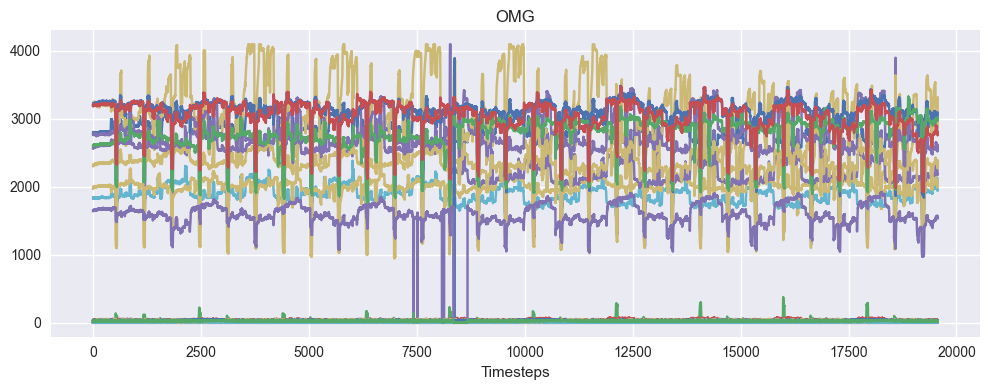

In [7]:
fig = plt.figure(figsize=(10, 4))
plt.plot(gestures[OMG_CH].values)
plt.title('OMG')
plt.xlabel('Timesteps')
plt.tight_layout()

### Protocol

In [5]:
gestures_protocol = pd.read_csv(f'{palm_file}.protocol.csv', index_col=0)
gestures_protocol.head(10)

Thumb  Index  Middle  Ring  Pinky  Thumb_stretch  Index_stretch  \
epoch                                                                    
0        0.0    0.0     0.0   0.0    0.0            0.0            0.0   
1        0.0    0.0     0.0   0.0    0.0            0.0            0.0   
2        1.0    0.0     0.0   0.0    0.0            0.0            0.0   
3        1.0    1.0     1.0   1.0    1.0            0.0            0.0   
4        0.0    0.0     0.0   0.0    0.0            1.0            1.0   
5        1.0    1.0     0.0   0.0    0.0            0.0            0.0   
6        0.0    0.0     1.0   1.0    1.0            0.0            0.0   
7        0.0    0.0     0.0   0.0    0.0            0.0            0.0   
8        1.0    0.0     0.0   0.0    0.0            0.0            0.0   
9        1.0    1.0     1.0   1.0    1.0            0.0            0.0   

       Middle_stretch  Ring_stretch  Pinky_stretch  Pronation  
epoch                                                          
0                 0.0           0.0            0.0        0.0  
1                 0.0           0.0            0.0        0.0  
2                 0.0           0.0            0.0        0.0  
3                 0.0           0.0            0.0        0.0  
4                 1.0           1.0            1.0        0.0  
5                 0.0           0.0            0.0        0.0  
6                 0.0           0.0            0.0        0.0  
7                 0.0           0.0            0.0        0.5  
8                 0.0           0.0            0.0        0.5  
9                 0.0           0.0            0.0        0.5

In [9]:
gestures['SYNC'].value_counts()

SYNC
0      11266
57        58
67        58
97        47
135       47
       ...  
52        46
1         45
103       45
104       45
12        39
Name: count, Length: 181, dtype: int64

In [6]:
le = LabelEncoder()

# FIT
le.fit(
    gestures_protocol[[
        "Thumb","Index","Middle","Ring","Pinky",
        'Thumb_stretch','Index_stretch','Middle_stretch','Ring_stretch','Pinky_stretch'
    ]]
    .apply(lambda row: str(tuple(row)), axis=1)
)

# TRANSFORM
gestures_protocol['gesture'] = le.transform(
    gestures_protocol[[
        "Thumb","Index","Middle","Ring","Pinky",
        'Thumb_stretch','Index_stretch','Middle_stretch','Ring_stretch','Pinky_stretch'
    ]]
    .apply(lambda row: str(tuple(row)), axis=1)
)
    
display(np.c_[le.transform(le.classes_), le.classes_])

array([[0, '(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [1, '(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0)'],
       [2, '(0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [3, '(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [4, '(1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [5, '(1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)']],
      dtype=object)

In [7]:
GESTURES = ['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']
GESTURES

['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']

In [12]:
gestures_protocol['gesture']

epoch
0      0
1      0
2      3
3      5
4      1
      ..
176    3
177    5
178    1
179    4
180    2
Name: gesture, Length: 181, dtype: int64

In [8]:
y_cmd = np.array([gestures_protocol['gesture'].loc[s] for s in gestures['SYNC'].values])
y_cmd

array([0, 0, 0, ..., 0, 0, 0])

# EDA

In [9]:
data = gestures[OMG_CH].copy()
data['gesture'] = y_cmd
data.describe()

0             1             2             3             4  \
count  19568.000000  19568.000000  19568.000000  19568.000000  19568.000000   
mean      10.488297      6.416650      5.474499      4.545482      2.196699   
std        5.108809      2.154009      2.204884      1.982026      1.504935   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%       10.000000      6.000000      5.000000      4.000000      2.000000   
50%       11.000000      6.000000      5.000000      4.000000      2.000000   
75%       12.000000      7.000000      6.000000      5.000000      2.000000   
max       32.000000     20.000000     19.000000     19.000000     16.000000   

                  5             6             7             8             9  \
count  19568.000000  19568.000000  19568.000000  19568.000000  19568.000000   
mean       1.399888      5.114217      4.839381      9.614013      8.244430   
std        1.706829      1.988027      2.052191      2.127120      2.136569   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      4.000000      4.000000      9.000000      8.000000   
50%        1.000000      5.000000      5.000000     10.000000      8.000000   
75%        2.000000      6.000000      6.000000     10.000000      9.000000   
max       16.000000     19.000000     19.000000     24.000000     20.000000   

       ...            41            42            43            44  \
count  ...  19568.000000  19568.000000  19568.000000  19568.000000   
mean   ...     21.539708     13.609822      9.198078      2.753373   
std    ...      3.216130      2.577426      2.226462      1.669041   
min    ...      5.000000      0.000000      0.000000      0.000000   
25%    ...     20.000000     13.000000      8.000000      2.000000   
50%    ...     22.000000     14.000000      9.000000      3.000000   
75%    ...     23.000000     14.000000     10.000000      3.000000   
max    ...     38.000000     29.000000     25.000000     16.000000   

                 45            46            47            48            49  \
count  19568.000000  19568.000000  19568.000000  19568.000000  19568.000000   
mean       1.498671     11.506950     12.482063     36.447619     26.996372   
std        1.692548      2.048213      2.076792      3.038738      4.483656   
min        0.000000      0.000000      0.000000     24.000000      0.000000   
25%        0.000000     10.000000     12.000000     34.000000     26.000000   
50%        1.000000     12.000000     12.000000     36.000000     28.000000   
75%        2.000000     12.000000     13.000000     38.000000     29.000000   
max       17.000000     27.000000     27.000000     54.000000    142.000000   

            gesture  
count  19568.000000  
mean       1.061069  
std        1.664630  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        2.000000  
max        5.000000  

[8 rows x 51 columns]

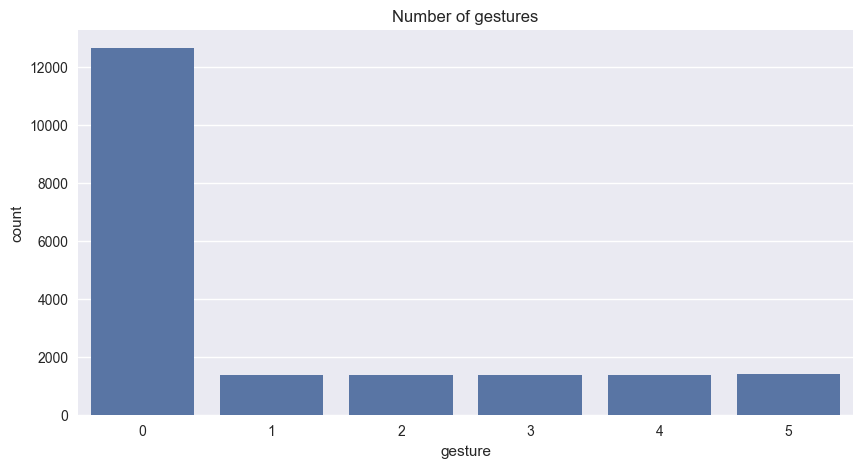

In [15]:
plt.figure(figsize = (10, 5))
sns.countplot(x = 'gesture', data = data)
plt.title("Number of gestures")
plt.show()

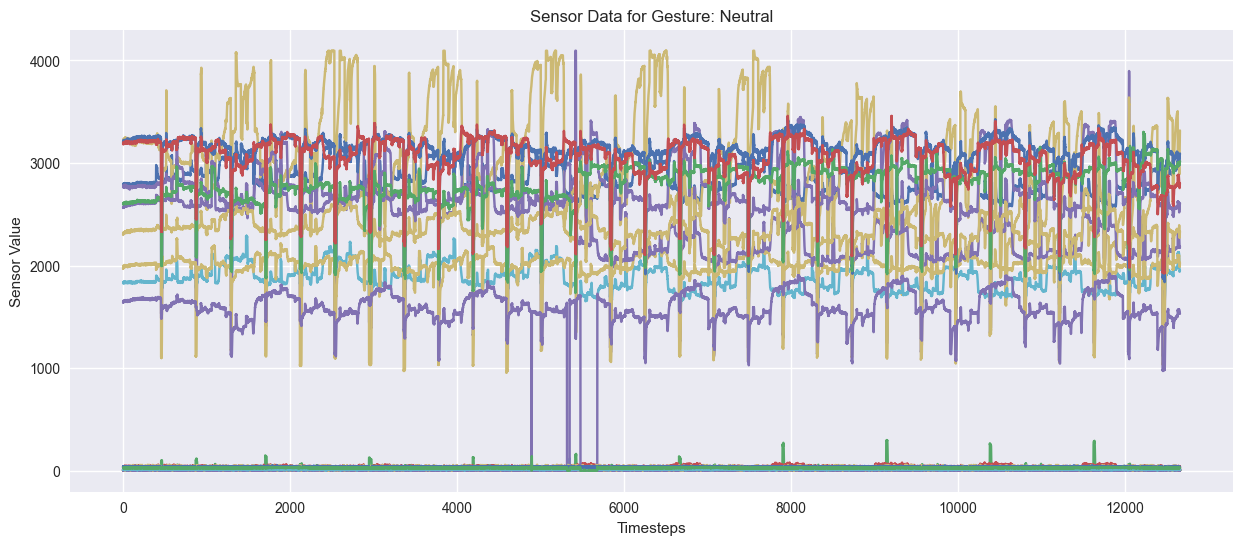

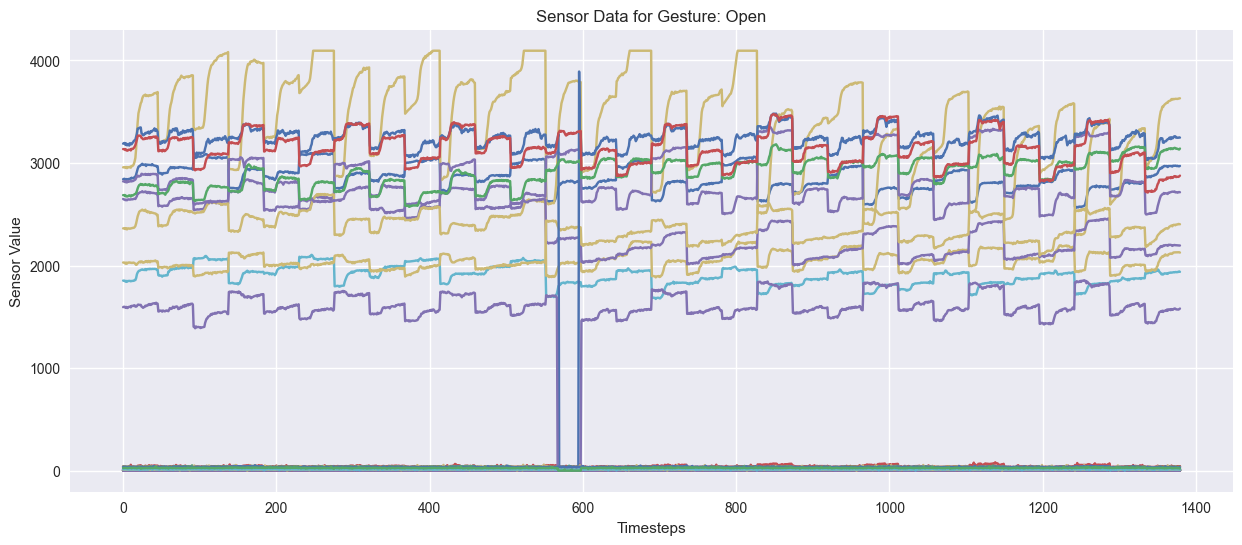

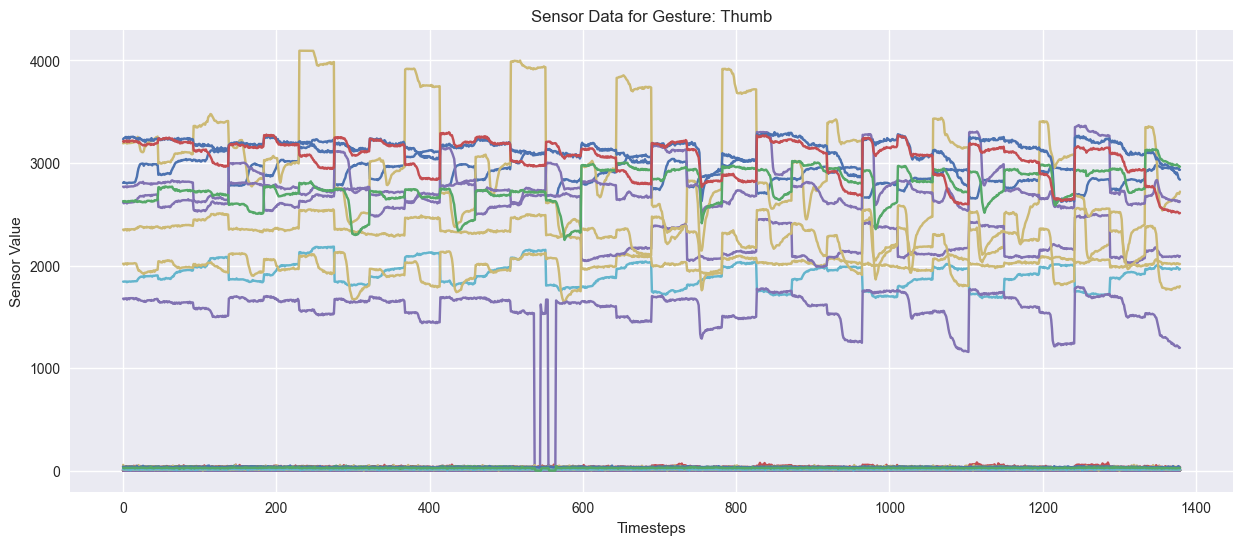

In [16]:
for i in range(6):
    data_gesture = data[data['gesture'] == i]
    plt.figure(figsize=(15, 6))
    plt.plot(data_gesture[OMG_CH].values)
    plt.xlabel('Timesteps')
    plt.ylabel('Sensor Value')
    plt.title(f'Sensor Data for Gesture: {GESTURES[i]}')
    plt.show()

In [17]:
derivatives = data[OMG_CH].diff()

# порог для выявления резких скачков
threshold = 1000 

# Поиск мест с резкими скачками для каждого датчика
jump_locations = {}
for col in derivatives.columns:
    peaks, _ = find_peaks(np.abs(derivatives[col]), height=threshold)
    if len(peaks) > 0:
        jump_locations[col] = peaks

# Вывод места с резкими скачками для каждого датчика
if len(jump_locations) > 0:
    print("Датчики с аномалиями:")
    for col, locations in jump_locations.items():
        print(f"Датчик {col}: {locations}")

Датчики с аномалиями:
Датчик 21: [18594]
Датчик 28: [18594]
Датчик 30: [8353 8379]
Датчик 39: [7428 7431 7509 7517 8083 8115 8124 8134 8351 8676]


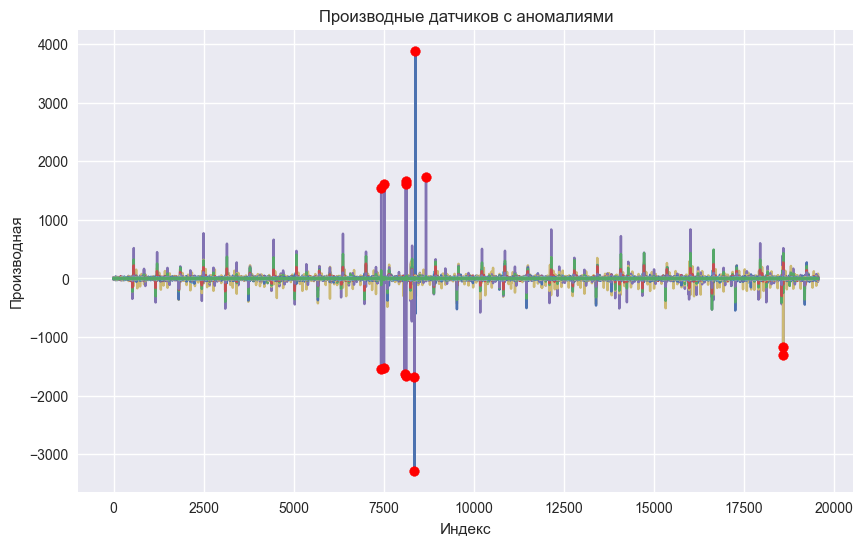

In [18]:
plt.figure(figsize=(10, 6))

# Построим графики производных для каждого датчика
for col in derivatives.columns:
    plt.plot(derivatives.index, derivatives[col], label=col)

# Выведем аномалии
for sensor, anomalies in jump_locations.items():
    plt.scatter(anomalies, derivatives.loc[anomalies, sensor], color='red', label=f'{sensor} - аномалии', zorder=5)

# Добавим легенду и другие детали графика
plt.title('Производные датчиков с аномалиями')
plt.xlabel('Индекс')
plt.ylabel('Производная')
plt.grid(True)
plt.show()

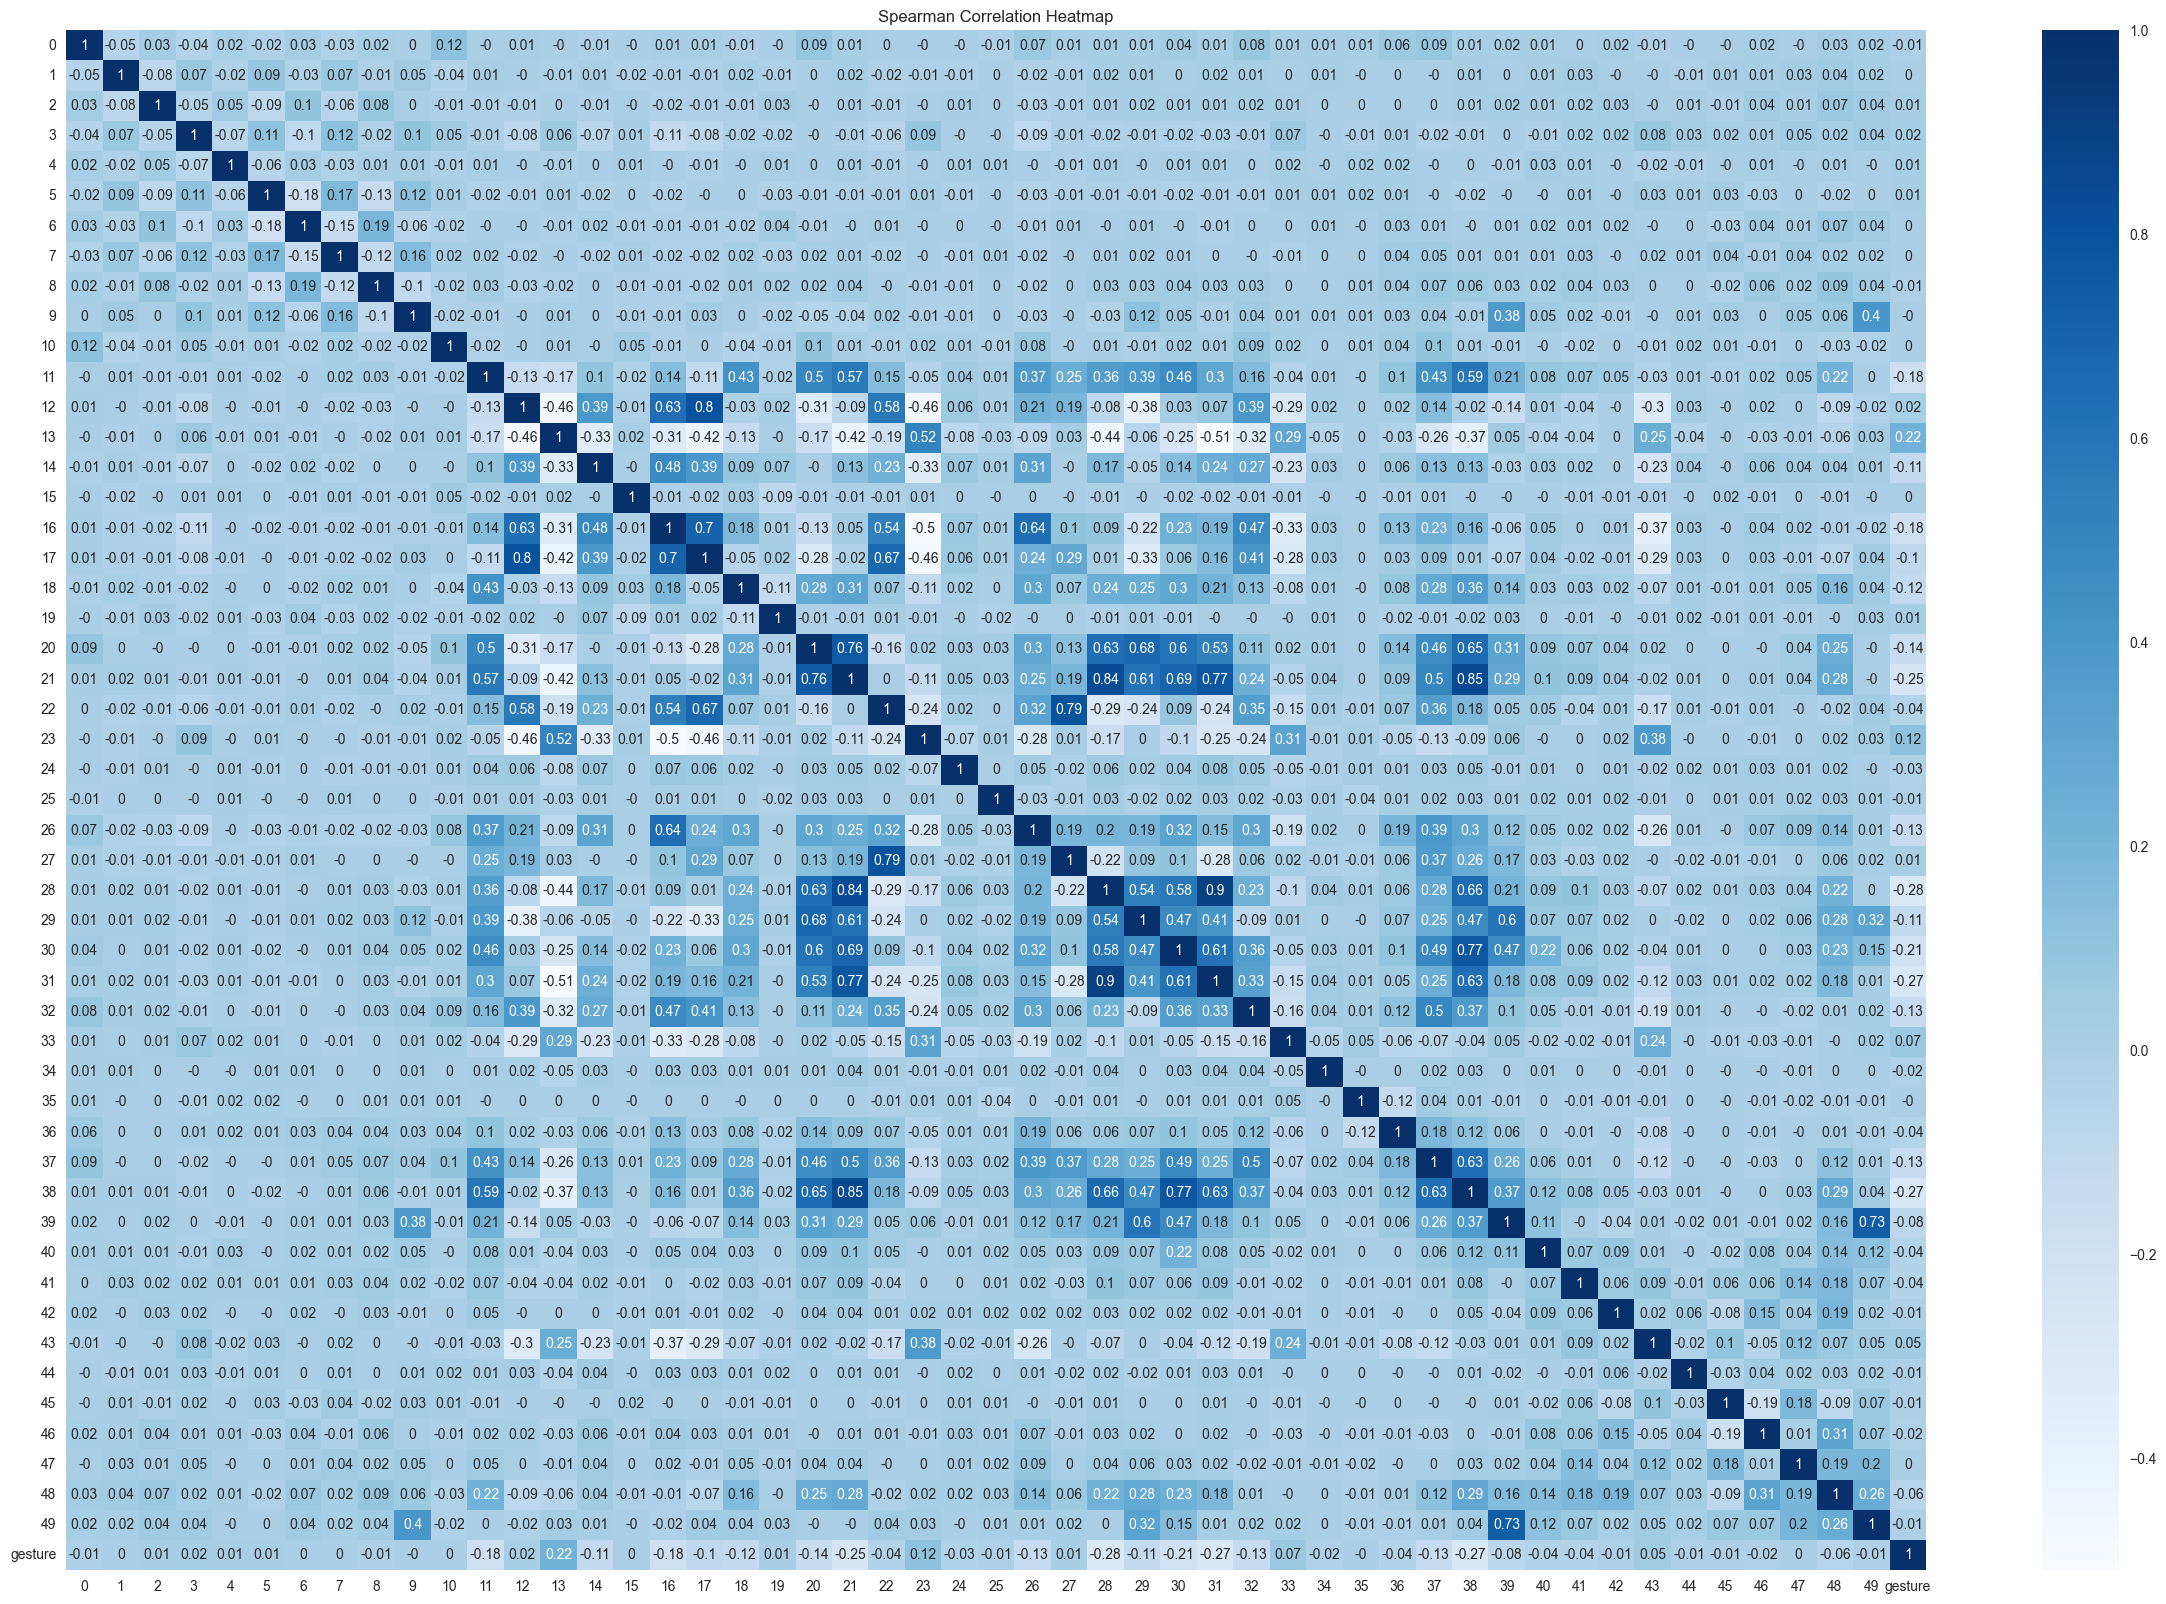

In [19]:
plt.figure(figsize=(30, 20))
sns.heatmap(data.corr().round(2), cmap = 'Blues', annot = True).set_title('Correlation matrix', fontsize = 14)
plt.title('Spearman Correlation Heatmap')
plt.show()

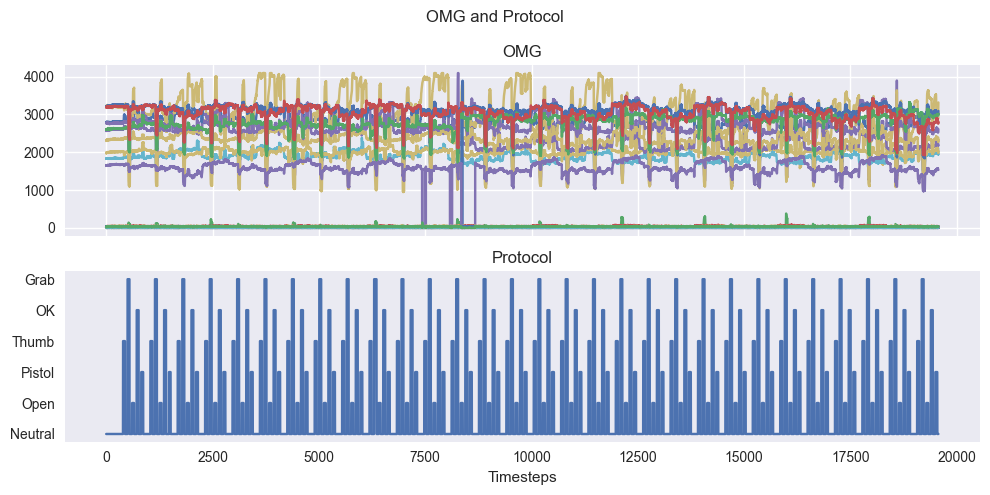

In [20]:
fig, axx = plt.subplots(2, 1, sharex=True, figsize=(10, 5))
plt.sca(axx[0])
plt.plot(data[OMG_CH].values)
plt.title('OMG')

plt.sca(axx[1])
plt.plot(data['gesture'].values)
plt.grid()
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.xlabel('Timesteps')
plt.title('Protocol')

plt.suptitle('OMG and Protocol')
plt.tight_layout()

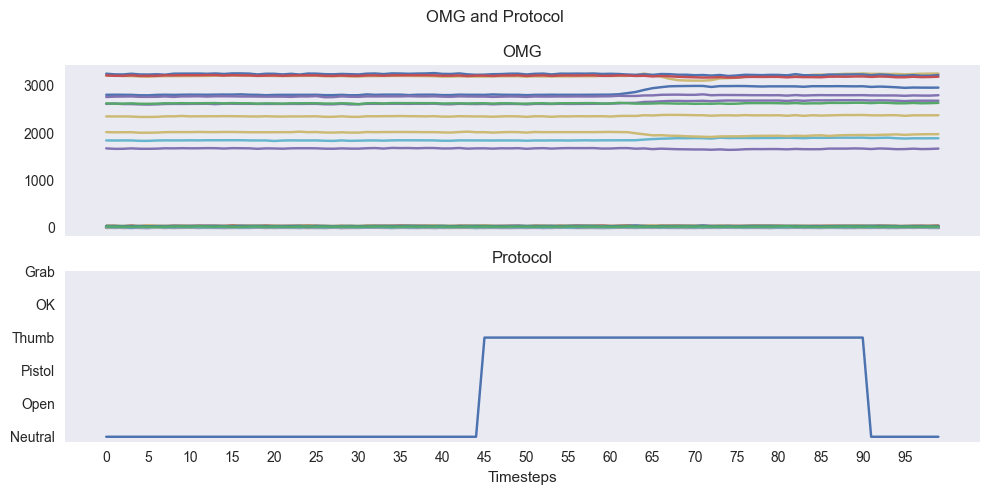

In [21]:
fig, axx = plt.subplots(2, 1, sharex=True, figsize=(10, 5))
plt.sca(axx[0])
plt.grid()
plt.plot(data[OMG_CH].values[350:450])
plt.xticks(np.arange(0, 100, 5))   
plt.title('OMG')

plt.sca(axx[1])
plt.plot(data['gesture'].values[350:450])  
plt.grid()
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.xticks(np.arange(0, 100, 5)) 
plt.xlabel('Timesteps')
plt.title('Protocol')

plt.suptitle('OMG and Protocol')
plt.tight_layout()

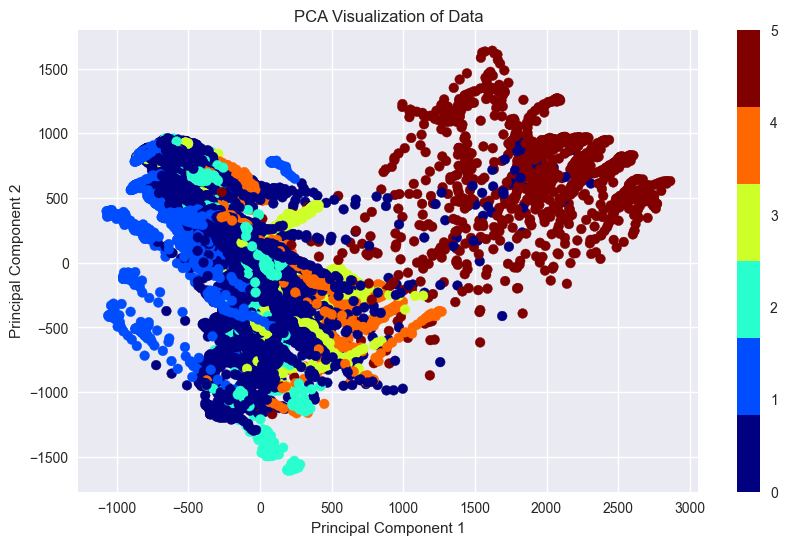

In [44]:
from sklearn.decomposition import PCA
import plotly.express as px

# Применение PCA для уменьшения размерности до 3 компонент
pca = PCA(n_components=2)
X_pca = pca.fit_transform(data)

# Создание DataFrame для Plotly Express
px_data = {
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'Class': y_cmd
}
px_df = pd.DataFrame(px_data)

# Визуализация данных
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_cmd, cmap=plt.cm.get_cmap('jet', 6))
plt.colorbar(ticks=range(6))
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Visualization of Data')
plt.show()

# Removing outliers

In [10]:
# indices_to_drop = [8353, 8379, 7428, 7431, 7509, 7517, 8083, 8115, 8124, 8134, 8351, 8676] 
# train_df = train_df.drop(indices_to_drop).reset_index(drop=True)

# print(train_df.shape)

# Delay elimination

In [16]:
def data_shifter(data, n):
    """Смещает данные на n единиц

    Args:
        data: Данные
        n: Кол-во единиц

    Returns:
        X: Смещенные данные
    """
    X = data.drop('gesture', axis=1) #Матрица наблюдений
    y = data['gesture'] #Вектор правильных ответов
    #Смещаем данные
    X = X.iloc[n:].reset_index(drop=True)
    X['gesture'] = y.iloc[:-n].reset_index(drop=True)
    return X

def get_sum_derivative(data):
    """Возвращает сумму абсолютных значений производных

    Args:
        data: Наши данные

    Returns:
        result: Серия сумм абсолютных значений производных
    """
    result = abs(data.drop('gesture', axis=1).diff()).sum(axis=1)
    return result

def get_best_shifter(data, res_plot=False):
    #Формируем ряд выполнения жестов.
    gestures = data['gesture'].apply(lambda x: 500 if x > 0 else 0)
    #Ряд производных
    derivatives = get_sum_derivative(data)
    #Словарь с результатом
    result = {'n': 0, 'cor': 0}
    #Находим лучший шифтер
    for n in range(1, 41):
        cor = np.corrcoef(derivatives.iloc[n:].values, gestures.iloc[:-n].values)[0][1]
        if cor > result['cor']:
            result['n'] = n
            result['cor'] = cor
            
    if res_plot: #Если необходимо строим график с полученным сдвигом для первых 2000 таймстепов.
        fig, axes = plt.subplots(1, 1, figsize=(16, 8))
        sns.lineplot(derivatives.iloc[result['n']:].values[300:2001], ax=axes, legend=False)
        sns.lineplot(gestures.iloc[:-result['n']].values[300:2001], ax=axes, legend=False)
        plt.tight_layout()
    #Выводим результат    
    print(f'n: {result["n"]}, cor: {result["cor"]}')
    #Возвращаем словарь с найденным n и корреляцией
    return result

n: 18, cor: 0.17341284650177377


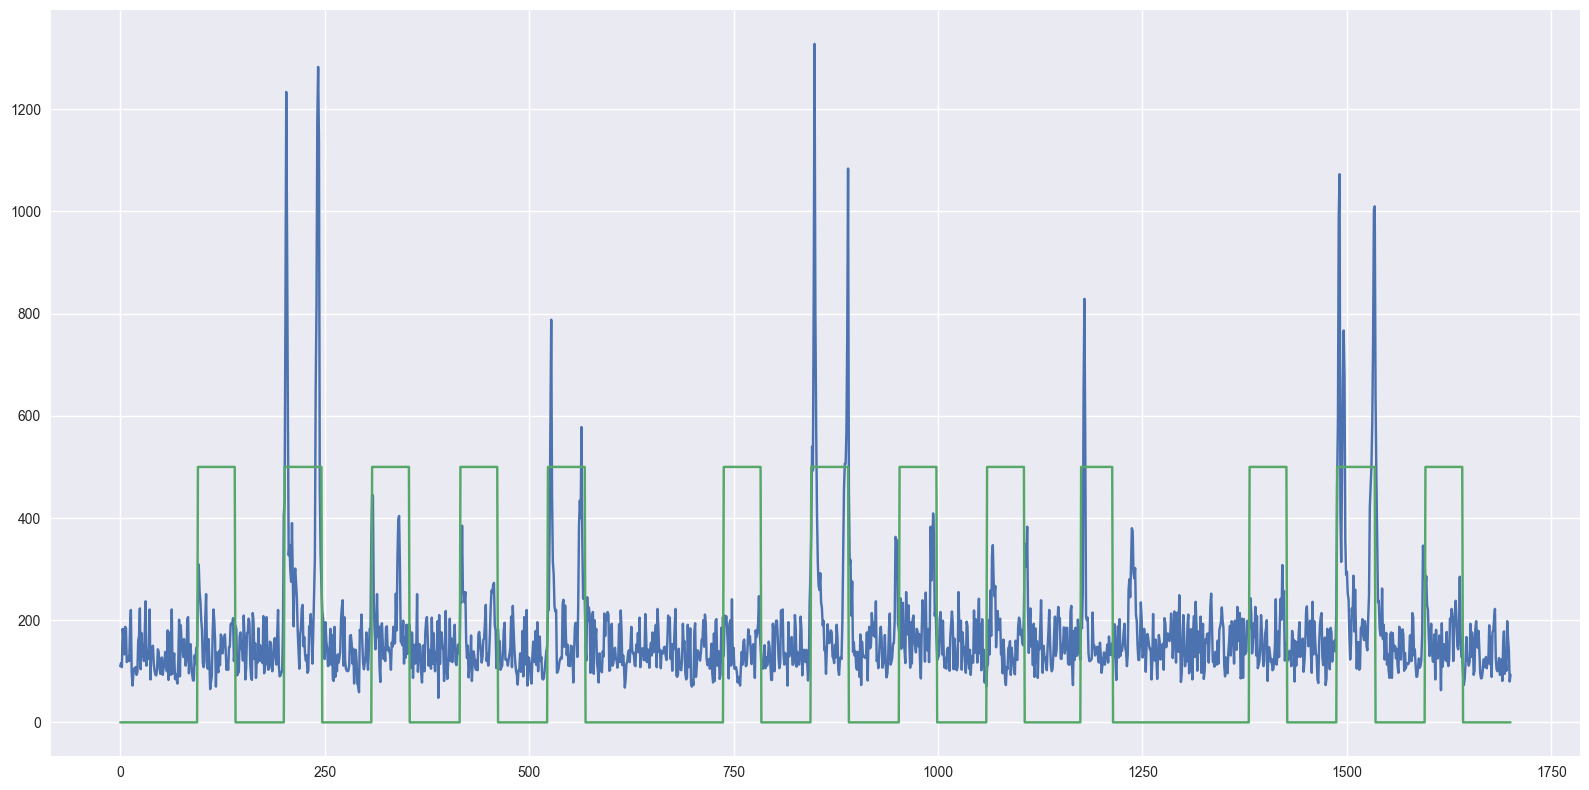

In [17]:
#Применяем полученную функцию
n = get_best_shifter(data, res_plot=True)['n']

In [19]:
#Применяем функцию
data = data_shifter(data, n)
print(f'Data shape: {data.shape}')
data

Data shape: (19550, 51)


0  1  2  3  4  5  6  7   8   9  ...  41  42  43  44  45  46  47  48  \
0      17  6  4  6  3  0  4  6  10   9  ...  21  11   8   2   2  10  10  33   
1      11  6  5  4  2  0  6  3  10   8  ...  23  15   9   1   0  11  14  37   
2      11  8  7  4  2  0  4  1  10   8  ...  24  12  12   2   1  12  10  39   
3      10  6  6  4  1  0  7  5  10   6  ...  24  14  11   2   0   1  14  40   
4      10  6  6  4  2  1  4  4   0  12  ...  20  14  11   0   2  13  14  38   
...    .. .. .. .. .. .. .. ..  ..  ..  ...  ..  ..  ..  ..  ..  ..  ..  ..   
19545   3  6  7  4  2  0  6  3  13   8  ...  24  13  10   3   2  11  13  34   
19546  26  6  5  3  2  1  4  4   9   7  ...  21  13  10   3   2  10  12  34   
19547  14  7  6  4  2  0  6  5  13   8  ...  25  14  13   3   1  12  12  37   
19548  30  6  6  4  2  0  5  5  10   6  ...  20   4   9   3   0  13  11  37   
19549  11  6  6  4  2  1  5  5  11   7  ...  22  15   9   3   0  13  11  40   

       49  gesture  
0      26        0  
1      29        0  
2      27        0  
3      27        0  
4      28        0  
...    ..      ...  
19545  28        0  
19546  27        0  
19547  27        0  
19548  27        0  
19549  28        0  

[19550 rows x 51 columns]

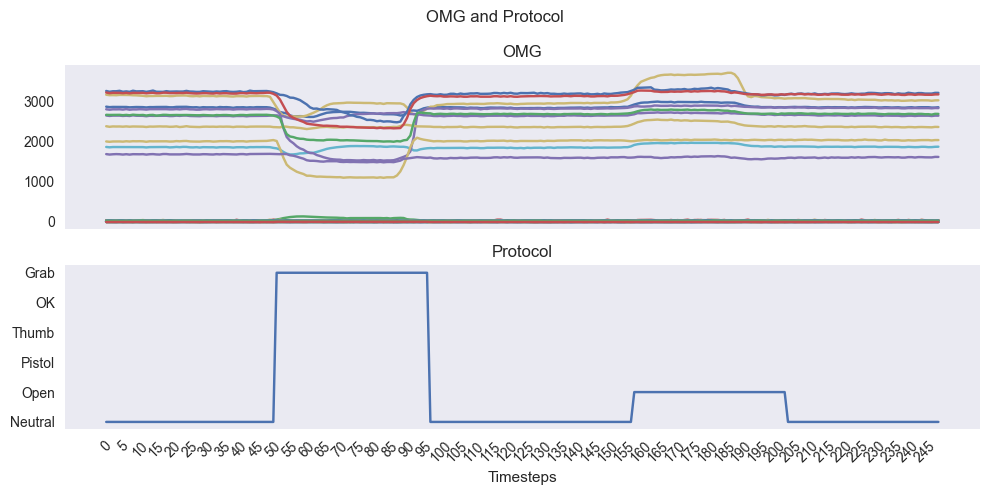

In [20]:
fig, axx = plt.subplots(2, 1, sharex=True, figsize=(10, 5))
plt.sca(axx[0])
plt.grid()
plt.plot(data.values[450:700])
plt.xticks(np.arange(0, 250, 5))   
plt.title('OMG')

plt.sca(axx[1])
plt.plot(data['gesture'].values[450:700])  
plt.grid()
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.xticks(np.arange(0, 250, 5)) 
plt.xticks(rotation=45)
plt.xlabel('Timesteps')
plt.title('Protocol')

plt.suptitle('OMG and Protocol')
plt.tight_layout()

# Train-test split

In [2]:
df_meta = pd.read_csv('./data/meta_information.csv', index_col=0)
df_meta.head()

montage  pilote_id  last_train_idx  len(train)  len(test)
0  2023-05-15_16-16-08.palm          1           23337       23337       5810
1  2023-05-15_17-12-24.palm          1           23336       23336       5803
2  2023-06-05_16-12-38.palm          1           17939       17939       4431
3  2023-06-05_17-53-01.palm          1           17771       17771       4435
4  2023-06-20_14-43-11.palm          1           17936       17936       4441

In [5]:
df_meta

montage  pilote_id  last_train_idx  \
0                  2023-05-15_16-16-08.palm          1           23337   
1                  2023-05-15_17-12-24.palm          1           23336   
2                  2023-06-05_16-12-38.palm          1           17939   
3                  2023-06-05_17-53-01.palm          1           17771   
4                  2023-06-20_14-43-11.palm          1           17936   
5                  2023-06-20_13-30-15.palm          1           17928   
6                  2023-06-20_12-34-17.palm          1           17758   
7                  2023-09-30_08-06-44.palm          2            5693   
8                  2023-09-29_11-03-50.palm          2            5694   
9                  2023-09-29_09-20-47.palm          2            5690   
10                 2023-09-13_22-14-05.palm          2            2769   
11                 2023-09-12_14-59-23.palm          2            2759   
12                 2023-09-12_12-55-22.palm          2            2760   
13                 2023-05-31_17-14-41.palm          2           15679   
14                 2023-05-31_15-46-37.palm          2           15676   
15                 2023-05-22_20-22-01.palm          2           15602   
16                 2023-05-22_17-04-29.palm          2           23289   
17                 2023-05-19_12-04-02.palm          2           23297   
18  2023-04-18_19-08-47 gestures train.palm          3           29532   
19                 2023-05-07_16-54-27.palm          3            5747   
20                 2023-05-07_15-19-05.palm          3            5361   
21                 2023-05-12_19-17-00.palm          3           13506   
22                 2023-05-05_17-57-30.palm          4           20756   
23                 2023-10-25_11-08-46.palm          2            3539   
24         patched_2023-10-25_09-44-02.palm          2            5675   
25                 2023-10-25_08-52-30.palm          2            5674   
26                 2023-10-23_16-23-02.palm          2            5675   
27                 2023-10-23_14-07-13.palm          2            5675   
28                 2023-10-23_10-11-45.palm          2            5677   
29                 2023-10-18_08-05-29.palm          2            5681   
30                 2023-10-18_11-16-21.palm          2            5677   

    len(train)  len(test)  
0        23337       5810  
1        23336       5803  
2        17939       4431  
3        17771       4435  
4        17936       4441  
5        17928       4435  
6        17758       4444  
7         5693       5509  
8         5694       5511  
9         5690       5507  
10        2769       2951  
11        2759       2944  
12        2760       2944  
13       15679       3891  
14       15676       3892  
15       15602       3872  
16       23289       5796  
17       23297       5795  
18       29532       8078  
19        5747       5569  
20        5361       5884  
21       13506       3333  
22       20756       5894  
23        3539       3427  
24        5675       5496  
25        5674       5496  
26        5675       5495  
27        5675       5496  
28        5677       5498  
29        5681       5503  
30        5677       5499

In [21]:
last_train_idx = df_meta[df_meta['montage'] == palm_file.split('/')[-1]].to_dict(orient='records')[0]['last_train_idx']
last_train_idx

15679

In [22]:
X_train = data.drop("gesture", axis=1)[:last_train_idx].reset_index(drop=True)
y_train = data['gesture'][:last_train_idx].reset_index(drop=True)

X_test = data.drop("gesture", axis=1)[last_train_idx:].reset_index(drop=True)
y_test = data['gesture'][last_train_idx:].reset_index(drop=True)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(15679, 50) (15679,)
(3871, 50) (3871,)


# Modeling

In [33]:
# Установка seed для воспроизводимости результатов
seed = 42
np.random.seed(seed)
random.seed(seed)
catboost_random_seed = seed

model = CatBoostClassifier(iterations=1000, 
                           learning_rate=0.1, 
                           depth=6, 
                           loss_function='MultiClass', 
                           random_seed=catboost_random_seed)
model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=100)

0:	learn: 1.5177781	test: 1.5827185	best: 1.5827185 (0)	total: 142ms	remaining: 2m 21s
100:	learn: 0.1902212	test: 0.4091219	best: 0.4085406 (98)	total: 5.07s	remaining: 45.2s
200:	learn: 0.1495128	test: 0.3899478	best: 0.3887616 (189)	total: 8.79s	remaining: 34.9s
300:	learn: 0.1294443	test: 0.3857530	best: 0.3847644 (284)	total: 12.5s	remaining: 29.1s
400:	learn: 0.1128251	test: 0.3772011	best: 0.3764694 (397)	total: 17s	remaining: 25.4s
500:	learn: 0.1005412	test: 0.3736055	best: 0.3736055 (500)	total: 22.5s	remaining: 22.4s
600:	learn: 0.0901910	test: 0.3719831	best: 0.3719831 (600)	total: 26.3s	remaining: 17.5s
700:	learn: 0.0808641	test: 0.3697593	best: 0.3691518 (692)	total: 29.8s	remaining: 12.7s
800:	learn: 0.0729526	test: 0.3684740	best: 0.3665004 (781)	total: 33.3s	remaining: 8.26s
900:	learn: 0.0659448	test: 0.3655664	best: 0.3648174 (877)	total: 37.6s	remaining: 4.13s
999:	learn: 0.0601927	test: 0.3652814	best: 0.3646939 (957)	total: 42s	remaining: 0us

bestTest = 0.364693

## Prediction

In [34]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

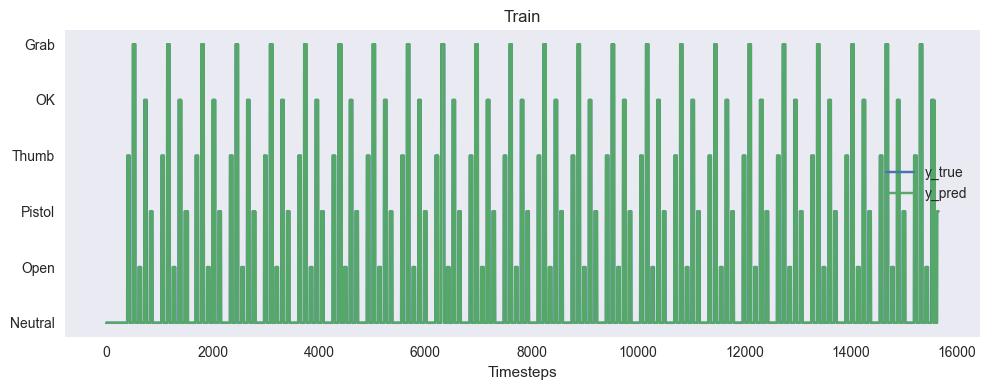

In [35]:
fig = plt.figure(figsize=(10, 4))
plt.plot(y_train,  c='C0', label='y_true')
plt.plot(y_pred_train, c='C1', label='y_pred')

plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.grid()
plt.xlabel('Timesteps')
plt.legend()
plt.title('Train')
plt.tight_layout()

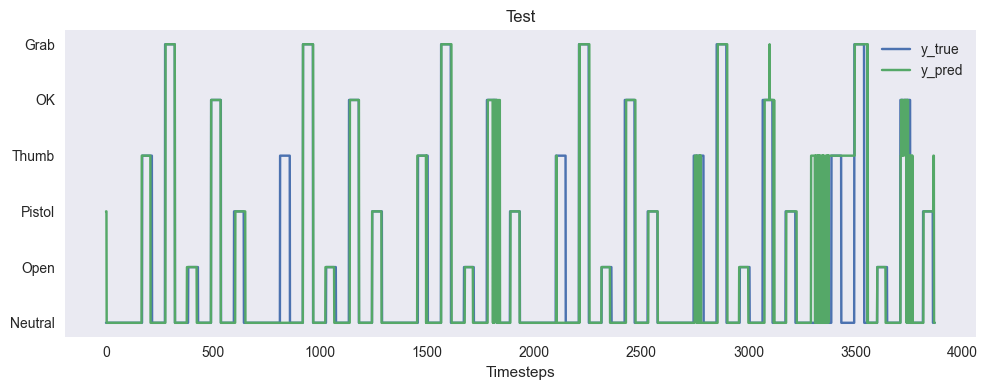

In [36]:
fig = plt.figure(figsize=(10, 4))
plt.plot(y_test,  c='C0', label='y_true')
plt.plot(y_pred_test, c='C1', label='y_pred')

plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.grid()
plt.xlabel('Timesteps')
plt.legend()
plt.title('Test')
plt.tight_layout()

## Metrics

In [37]:
print(classification_report(y_train, y_pred_train, target_names=GESTURES))
print(classification_report(y_test, y_pred_test, target_names=GESTURES))

              precision    recall  f1-score   support

     Neutral       0.98      0.99      0.99     10146
        Open       0.99      0.95      0.97      1101
      Pistol       0.99      0.97      0.98      1080
       Thumb       0.98      0.97      0.97      1100
          OK       0.98      0.94      0.96      1104
        Grab       0.99      0.98      0.99      1118

    accuracy                           0.98     15649
   macro avg       0.99      0.97      0.98     15649
weighted avg       0.98      0.98      0.98     15649

              precision    recall  f1-score   support

     Neutral       0.90      0.91      0.91      2490
        Open       0.95      0.85      0.89       276
      Pistol       0.93      0.93      0.93       276
       Thumb       0.47      0.51      0.49       276
          OK       0.93      0.80      0.86       276
        Grab       0.90      0.96      0.93       277

    accuracy                           0.88      3871
   macro avg       0.85

# Feature Engineering

In [23]:
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import settings

In [25]:
settings_efficient = settings.EfficientFCParameters()
settings_efficient

{'variance_larger_than_standard_deviation': None, 'has_duplicate_max': None, 'has_duplicate_min': None, 'has_duplicate': None, 'sum_values': None, 'abs_energy': None, 'mean_abs_change': None, 'mean_change': None, 'mean_second_derivative_central': None, 'median': None, 'mean': None, 'length': None, 'standard_deviation': None, 'variation_coefficient': None, 'variance': None, 'skewness': None, 'kurtosis': None, 'root_mean_square': None, 'absolute_sum_of_changes': None, 'longest_strike_below_mean': None, 'longest_strike_above_mean': None, 'count_above_mean': None, 'count_below_mean': None, 'last_location_of_maximum': None, 'first_location_of_maximum': None, 'last_location_of_minimum': None, 'first_location_of_minimum': None, 'percentage_of_reoccurring_values_to_all_values': None, 'percentage_of_reoccurring_datapoints_to_all_datapoints': None, 'sum_of_reoccurring_values': None, 'sum_of_reoccurring_data_points': None, 'ratio_value_number_to_time_series_length': None, 'maximum': None, 'absolu

In [26]:
data_long = pd.DataFrame({0: data.values.flatten(),
                          1: np.arange(data.shape[0]).repeat(data.shape[1])})
print(data_long.shape)
data_long.head()

(997050, 2)


0  1
0  17  0
1   6  0
2   4  0
3   6  0
4   3  0

In [27]:
data_tsfresh = extract_features(data_long, column_id=1, impute_function=impute, default_fc_parameters=settings_efficient)
print(data_tsfresh.shape)

Feature Extraction:   0%|          | 0/10 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 10/10 [18:10<00:00, 109.07s/it]


# Modeling and prediction with new extracted features

In [ ]:
X_train_tsfresh = data_tsfresh.drop("gesture", axis=1)[:last_train_idx].reset_index(drop=True)
y_train_tsfresh = data_tsfresh['gesture'][:last_train_idx].reset_index(drop=True)

X_test_tsfresh = data_tsfresh.drop("gesture", axis=1)[last_train_idx:].reset_index(drop=True)
y_test_tsfresh = data_tsfresh['gesture'][last_train_idx:].reset_index(drop=True)

print(X_train_tsfresh.shape, y_train.shape)
print(X_test_tsfresh.shape, y_test.shape)

In [56]:
model = CatBoostClassifier(iterations=1000, 
                           learning_rate=0.1, 
                           depth=6, 
                           loss_function='MultiClass', 
                           random_seed=catboost_random_seed)
model.fit(X_train_tsfresh, y_train, eval_set=(X_test_tsfresh, y_test), verbose=100)

0:	learn: 1.4699665	test: 1.5061647	best: 1.5061647 (0)	total: 4.81s	remaining: 1h 20m 8s
100:	learn: 0.1838116	test: 0.4040896	best: 0.4040896 (100)	total: 1m 46s	remaining: 15m 45s
200:	learn: 0.1378362	test: 0.3854952	best: 0.3832694 (183)	total: 3m 12s	remaining: 12m 44s
300:	learn: 0.1174604	test: 0.3747684	best: 0.3745250 (299)	total: 4m 17s	remaining: 9m 58s
400:	learn: 0.1015409	test: 0.3711515	best: 0.3698023 (367)	total: 5m 23s	remaining: 8m 3s
500:	learn: 0.0890518	test: 0.3671654	best: 0.3671654 (500)	total: 6m 33s	remaining: 6m 32s
600:	learn: 0.0783999	test: 0.3686716	best: 0.3661774 (529)	total: 8m 18s	remaining: 5m 31s
700:	learn: 0.0693819	test: 0.3704374	best: 0.3661774 (529)	total: 9m 48s	remaining: 4m 11s
800:	learn: 0.0623699	test: 0.3728591	best: 0.3661774 (529)	total: 10m 32s	remaining: 2m 37s
900:	learn: 0.0558181	test: 0.3770994	best: 0.3661774 (529)	total: 11m 18s	remaining: 1m 14s
999:	learn: 0.0501549	test: 0.3759973	best: 0.3661774 (529)	total: 12m 8s	remai

In [57]:
y_pred_train = model.predict(X_train_tsfresh)
y_pred_test = model.predict(X_test_tsfresh)

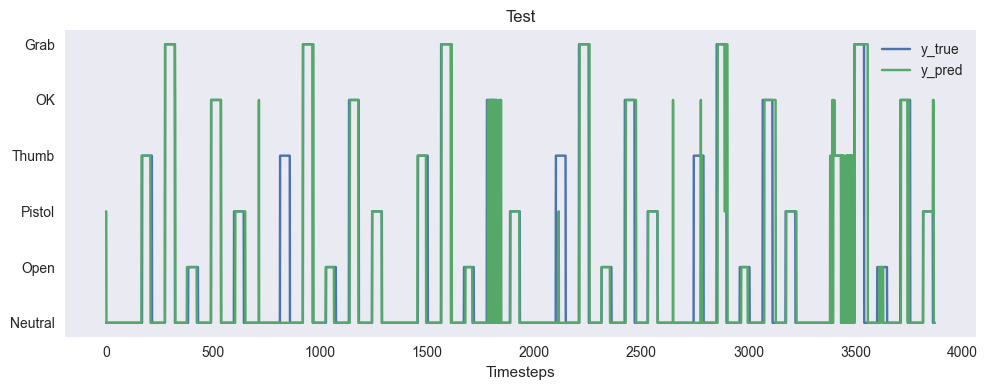

In [58]:
fig = plt.figure(figsize=(10, 4))
plt.plot(y_test,  c='C0', label='y_true')
plt.plot(y_pred_test, c='C1', label='y_pred')

plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.grid()
plt.xlabel('Timesteps')
plt.legend()
plt.title('Test')
plt.tight_layout()

In [59]:
print(classification_report(y_train, y_pred_train, target_names=GESTURES))
print(classification_report(y_test, y_pred_test, target_names=GESTURES))

              precision    recall  f1-score   support

     Neutral       0.97      0.99      0.98     10146
        Open       0.98      0.93      0.95      1101
      Pistol       0.99      0.95      0.97      1080
       Thumb       0.98      0.96      0.97      1100
          OK       0.98      0.93      0.95      1104
        Grab       0.99      0.97      0.98      1118

    accuracy                           0.98     15649
   macro avg       0.98      0.95      0.97     15649
weighted avg       0.98      0.98      0.98     15649

              precision    recall  f1-score   support

     Neutral       0.88      0.95      0.91      2490
        Open       0.96      0.70      0.81       276
      Pistol       0.92      0.94      0.93       276
       Thumb       0.77      0.41      0.54       276
          OK       0.83      0.79      0.81       276
        Grab       0.89      0.92      0.91       277

    accuracy                           0.88      3871
   macro avg       0.87

# Filtering new extracted features 

In [60]:
relevant_features = set()

for label in y_train.unique():
    y_train_binary = y_train == label
    X_train_filtered = select_features(X_train_tsfresh, y_train_binary)
    relevant_features = relevant_features.union(set(X_train_filtered.columns))

len(relevant_features)

393

In [62]:
X_train_filtered = X_train_tsfresh[list(relevant_features)]
X_test_filtered = X_test_tsfresh[list(relevant_features)]

model = CatBoostClassifier(iterations=1000, 
                           learning_rate=0.1, 
                           depth=6, 
                           loss_function='MultiClass', 
                           random_seed=catboost_random_seed)
model.fit(X_train_filtered, y_train, eval_set=(X_test_filtered, y_test), verbose=100)

y_pred_train = model.predict(X_train_filtered)
y_pred_test = model.predict(X_test_filtered)

print(classification_report(y_train, y_pred_train, target_names=GESTURES))
print(classification_report(y_test, y_pred_test, target_names=GESTURES))

0:	learn: 1.4659867	test: 1.5030014	best: 1.5030014 (0)	total: 2.77s	remaining: 46m 10s
100:	learn: 0.1824105	test: 0.3947876	best: 0.3947876 (100)	total: 1m 3s	remaining: 9m 26s
200:	learn: 0.1386826	test: 0.3780627	best: 0.3780627 (200)	total: 2m 39s	remaining: 10m 34s
300:	learn: 0.1135190	test: 0.3691437	best: 0.3691437 (300)	total: 3m 45s	remaining: 8m 44s
400:	learn: 0.0989094	test: 0.3681309	best: 0.3664353 (311)	total: 4m 52s	remaining: 7m 17s
500:	learn: 0.0863410	test: 0.3688915	best: 0.3663031 (440)	total: 5m 38s	remaining: 5m 36s
600:	learn: 0.0756634	test: 0.3677610	best: 0.3662040 (533)	total: 6m 39s	remaining: 4m 25s
700:	learn: 0.0666846	test: 0.3661251	best: 0.3652580 (676)	total: 7m 36s	remaining: 3m 14s
800:	learn: 0.0591126	test: 0.3685335	best: 0.3652580 (676)	total: 8m 27s	remaining: 2m 5s
900:	learn: 0.0528775	test: 0.3701528	best: 0.3652580 (676)	total: 9m 14s	remaining: 1m
999:	learn: 0.0474601	test: 0.3720273	best: 0.3652580 (676)	total: 10m	remaining: 0us

be

# Real-time inference

In [38]:
import time
import serial
from IPython.display import clear_output

ModuleNotFoundError: No module named 'serial'

In [ ]:
crc_table = [
    54, 181, 83, 241, 89, 16, 164, 217, 34, 169, 220, 160, 11, 252,
    111, 241, 33, 70, 99, 240, 234, 215, 60, 206, 68, 126, 152, 81,
    113, 187, 14, 21, 164, 172, 251, 16, 248, 215, 236, 90, 49, 53,
    179, 156, 101, 55, 65, 130, 161, 22, 218, 79, 24, 168, 152, 205,
    115, 141, 23, 86, 141, 58, 122, 215, 252, 48, 69, 115, 138, 66,
    88, 37, 63, 104, 176, 46, 139, 246, 222, 184, 103, 92, 154, 174,
    97, 141, 195, 166, 227, 150, 140, 48, 121, 243, 13, 131, 210, 199,
    45, 75, 180, 104, 97, 82, 251, 90, 132, 111, 229, 175, 146, 216,
    153, 86, 166, 33, 184, 100, 225, 248, 186, 54, 89, 39, 2, 214, 2,
    114, 197, 6, 35, 188, 245, 64, 220, 37, 123, 132, 190, 60, 189, 53,
    215, 185, 238, 145, 99, 226, 79, 54, 102, 118, 210, 116, 51, 247,
    0, 191, 42, 45, 2, 132, 106, 52, 63, 159, 229, 157, 78, 165, 50,
    18, 108, 193, 166, 253, 3, 243, 126, 111, 199, 152, 36, 114, 147,
    57, 87, 14, 16, 160, 128, 97, 189, 51, 115, 142, 8, 70, 71, 55, 42,
    193, 65, 207, 122, 158, 26, 21, 72, 139, 33, 230, 230, 116, 134, 5,
    213, 165, 107, 41, 134, 219, 190, 26, 29, 136, 174, 190, 108, 185, 172,
    137, 239, 164, 208, 207, 206, 98, 207, 12, 0, 174, 64, 20, 90, 49, 12,
    67, 112, 109, 78, 114, 165, 244, 183, 121
];
    
def get_crc(data, count):
    result = 0x00
    l = count
    while (count>0):   
        result = crc_table[result ^ data[l-count]]
        count -= 1;
    return result;

def drv_abs_one(ser, control):
    if ser is None:
        return
    pack = (np.array([80, 0x01, 0xBB, 6] + [c for c in control] + [0], dtype='uint8'))
    pack[-1] = get_crc(pack[1:], 9)
    return (pack, ser.write(bytearray(pack)))

## Inference Utils: Put your code here

In [ ]:
def preprocessing(x):
    # x - sample vector
    y = x
    return y

def inference(x):
    y = model.predict([x])
    return y

def postprocessing(x, prev):
    if prev is None:
        y = x
    else:
        y = x*0.1 + prev*0.9 # Holt-Winters filter
    return y

def commands(x):
    y = np.round(np.clip(x / 100, 0, 1)*100).astype(int)
    return y

## Inference

### Offline (dataset)

In [ ]:
df_sim = gestures.iloc[last_train_idx:]
print(df_sim.shape)

(3889, 65)


In [ ]:
TIMEOUT = 0.033
DEBUG = False
    
i = 0
ts_old = time.time()
ts_diff = 0;

y_previous = None
y_dct = {
    'omg_sample':[],
    'enc_sample':[],
    'sample_preprocessed':[],
    
    'y_predicted':[],
    'y_postprocessed':[],
    'y_commands':[],
}
while True:    
    
    # [Data reading]
    ts_start = time.time()
    
    try:
        # [Sim data]
        if i < len(df_sim):
            sample = df_sim.values[i]
        else:
            break
        # [/Sim data]
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
        
    except Exception as e:
        print(e)
        
    # [/Data Reading]
        
    # [Data preprocessing]
    sample_preprocessed = preprocessing(omg_sample)
    # [/Data preprocessing]
    
    # [Inference]
    y_predicted         = inference(sample_preprocessed)
    # [/Inference]
    
    # [Inference Postprocessing]
    y_postprocessed     = postprocessing(y_predicted, y_previous)
    # [/Inference Postprocessing]
    
    # [Commands composition]
    y_commands          = commands(y_postprocessed)
    # [/Commands composition]
    
    # [Commands sending]
    # NO COMMANDS SENDING IN SIMULATION
    # [/Commands sending]
    
    # [Data logging]
    y_dct['omg_sample'].append(omg_sample)
    y_dct['enc_sample'].append(enc_sample)
    y_dct['sample_preprocessed'].append(sample_preprocessed)
    y_dct['y_predicted'].append(y_predicted)
    y_dct['y_postprocessed'].append(y_postprocessed)
    y_dct['y_commands'].append(y_commands)
    # [/Data logging]

    y_previous = y_postprocessed
    
    if DEBUG:
        clear_output(wait=True)

        # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        print(y_commands)
    
    ts_diff = time.time() - ts_start
    assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    ts_old = ts_start
    i += 1 

In [ ]:
for key, val in y_dct.items():
    # print(f"len({key}) = {len(y_dct[key])}")
    y_dct[key] = np.stack(val)
    print(f"{key}.shape = {y_dct[key].shape}")

omg_sample.shape = (3889, 50)
enc_sample.shape = (3889, 6)
sample_preprocessed.shape = (3889, 50)
y_predicted.shape = (3889, 1)
y_postprocessed.shape = (3889, 1)
y_commands.shape = (3889, 1)


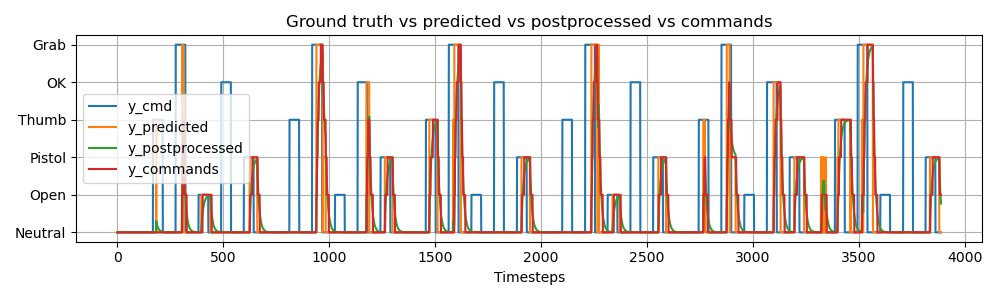

In [ ]:
fig = plt.figure(figsize=(10, 3))

plt.plot(y_test, c='C0', label='y_cmd')
plt.plot(y_dct['y_predicted'], c='C1', label='y_predicted')
plt.plot(y_dct['y_postprocessed'], c='C2', label='y_postprocessed')
plt.plot(y_dct['y_commands'], c='C3', label='y_commands')

plt.title('Ground truth vs predicted vs postprocessed vs commands')
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.legend()
plt.grid()
plt.xlabel('Timesteps')

plt.tight_layout()

In [ ]:
print(classification_report(y_test, y_dct['y_commands'], target_names=GESTURES))

              precision    recall  f1-score   support

     Neutral       0.67      0.78      0.72      2508
        Open       0.11      0.16      0.13       276
      Pistol       0.22      0.23      0.23       276
       Thumb       0.20      0.11      0.14       276
          OK       0.00      0.00      0.00       276
        Grab       0.12      0.02      0.04       277

    accuracy                           0.54      3889
   macro avg       0.22      0.22      0.21      3889
weighted avg       0.48      0.54      0.50      3889



### Online (prosthesis or virtual hand)

In [ ]:
TIMEOUT = 0.033
DEBUG = True

ser = None
# ser_port = None
# ser_port = '/dev/ttyACM0'
ser_port = '/dev/cu.usbmodem3498365F31351'

if ser_port is not None:
    ser = serial.Serial(port=ser_port, timeout=2*TIMEOUT)
    ser.write('T1#\r\n'.encode('utf-8')) # T1 for Timestamp activate
    ser.write('M2#\r\n'.encode('utf-8')) # M2 for Mode == 2 = send samples
    ser.write('S2#\r\n'.encode('utf-8')) # SYNC to 2 for sanity check

    # flush buffers
    ser.reset_input_buffer()
    ser.read()
    
    i = 0;
    while(ser.in_waiting):
        print(f'Flushing buffers {i}: {ser.in_waiting}', end='    \r')
        ser.read_all()
        time.sleep(0.005)
        i+=1;
    ser.readline()
    ser.readline()
    
i = 0
ts_old = time.time()
ts_diff = 0;

y_previous = None
while True:    
    
    # [Data reading]
    s = ser.readline()
    ts_start = time.time()
    
    try:
        sample = np.array(s.decode('UTF-8')\
                           .replace('\r\n', "")\
                           .split(' ')
                         ).astype(int)
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
        
    except Exception as e:
        print(e)
        
    # [/Data Reading]
        
    # [Data preprocessing]
    sample_preprocessed = preprocessing(omg_sample)
    # [/Data preprocessing]
    
    # [Inference]
    y_predicted         = inference(sample_preprocessed)
    # [/Inference]
    
    # [Inference Postprocessing]
    y_postprocessed     = postprocessing(y_predicted, y_previous)
    # [/Inference Postprocessing]
    
    # [Commands composition]
    y_commands          = commands(y_postprocessed)
    # [/Commands composition]
    
    # [Commands sending]
    pack, _ = drv_abs_one(ser, list(y_commands)); # + [0]
    # [/Commands sending]
    
    y_previous = y_postprocessed
    
    if DEBUG:
        clear_output(wait=True)

        # sanity check: iteration should increase monotonically, TIMEDIFF approximately 32-34 ms, CYCLETIME < TIMEOUT, WAITING should be == 0
        print(f'ITERATION:\t{i}\tTIMEDIFF:\t{(ts_start - ts_old)*1000: .0f}\tCYCLETIME:\t{ts_diff*1000:.0f}\tWAITING:\t{ser.in_waiting}')
        print('INPUT:\n', s)

        # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        print(y_commands)
        print(pack)
    
    ts_diff = time.time() - ts_start
    assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    ts_old = ts_start
    i += 1 